In [1]:
import hyppo
from hyppo.discrim import ClassDiscriminabilityTest
from hyppo.discrim._utils import _CheckInputs
from hyppo.independence import Dcorr
from dask.distributed import Client, progress
import dask.dataframe as ddf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA

# One Sample Dependencies

In [2]:
def statistic(x, y, z, is_distance=False, remove_isolates=True):
    r"""
    Calculates the independence test statistic.

    Parameters
    ----------
    x, y, z : ndarray of float
        Input data matrices.
    """
    # TODO: add something that checks whether z respects y
    # that is, for each *unique* individual in y, that all
    # of that unique individual's class labels are the same
    check_input = _CheckInputs(
        [x],
        y,
        is_dist=is_distance,
        remove_isolates=remove_isolates,
    )
    x, y = check_input()

    x = np.asarray(x[0])
    y = y
    z = z

    weights = []
    zs = np.unique(z)
    K = len(zs)
    N = x.shape[0]

    weights = np.zeros((K, K))
    discrs = np.zeros((K, K))
    for i, z1 in enumerate(zs):
        Nz1 = (z == z1).sum()
        for j, z2 in enumerate(zs):
            if z1 == z2:
                Nz2 = Nz1 - 1
            else:
                Nz2 = (z == z2).sum()
            weights[i, j] = Nz1*Nz2/(N*(N - 1))
            discrs[i, j] = _statistic_zzp(x, y, z, z1=z1, z2=z2)
    w = within_sub_discr(discrs, weights)
    b = between_sub_discr(discrs, weights)
    ratio = b/w
    return w, b, ratio

def _statistic_zzp(x, y, z, z1, z2):
    r"""
    Calulates the independence test statistic.

    Parameters
    ----------
    x, y : ndarray of float
        Input data matrices.
    """
    rdfs = []
    # isolate analysis to only elements from classes z1 or z2
    idx_z1z2 = np.where(np.logical_or(z == z1, z == z2))[0]
    y_z1z2 = y[idx_z1z2]
    z_z1z2 = z[idx_z1z2]
    for i in idx_z1z2:
        # the class label of object i
        z_i = z[i]
        y_i = y[i]
        # the individual label of object i
        ind_i = y[i]
        # get all of the distances from i to other items that have class
        # of z1 or z2, where the individual label is the same
        Dii = x[i][idx_z1z2][y_z1z2 == ind_i]
        if z_i == z1:
            z_oth = z2
        else:
            z_oth = z1
        # get all of the distances from i to other items that have
        # class of z1 or z2, where the individual label is different
        # and the class is the class that object i is not
        Dij = x[i][idx_z1z2][np.logical_and(z_z1z2 == z_oth, y_z1z2 != y_i)]

        rdf = [1 - ((Dij < d).sum() + 0.5 * (Dij == d).sum()) / Dij.size for d in Dii]
        rdfs.append(rdf)
    stat = np.array(rdfs).mean()
    return stat

def permute_z_respect_y(y, z, y_unique=None, unique_idx=None):
    if (y_unique is None) or (unique_idx is None):
        y_unique, unique_idx = np.unique(y, return_index=True)
    z_unique = z[unique_idx]
    z_unique_permuted = np.random.permutation(z_unique)
    z_permuted = np.zeros((len(y)))
    for i, yi in enumerate(y_unique):
        z_permuted[y == yi] = z_unique_permuted[i]
    return z_permuted
    
def one_sample_test(x, y, z, reps=1000, is_distance=False, remove_isolates=True):
    r"""
    Calculates the independence test statistic.

    Parameters
    ----------
    x, y, z : ndarray of float
        Input data matrices.
    """
    check_input = _CheckInputs(
        [x],
        y,
        is_dist=is_distance,
        remove_isolates=remove_isolates,
    )
    x, y = check_input()

    x = np.asarray(x[0])
    y = y
    z = z
    
    y_unique, unique_idx = np.unique(y, return_index=True)

    sample_stat = statistic(x, y, z, is_distance=True, remove_isolates=False)[2]
    
    # run permutation test
    null_stat = np.zeros((reps))
    for i in range(reps):
        null_stat[i] = statistic(x, y, permute_z_respect_y(y, z, y_unique=y_unique, unique_idx=unique_idx),
                                is_distance=True, remove_isolates=False)[2]
    pvalue = ((null_stat >= sample_stat).sum() + 1)/(reps + 1)
    return sample_stat, pvalue, null_stat

def manova_statistic():
    try:
        indep = pd.DataFrame({"Individual": y, "Class": z})
        model = MANOVA(x, indep)
        test = model.mv_test()
        return test.results["x1"]["stat"]["Value"][0]
    except:
        return np.nan
    
def dcorr_statistic():
    return Dcorr().statistic(x, z)

def one_sample_manova(x, y, z):
    try:
        indep = pd.DataFrame({"Individual": y, "Class": z})
        model = MANOVA(x, indep)
        test = model.mv_test()
        return test.results["x1"]["stat"]["Pr > F"][0]
    except:
        return np.nan

def one_sample_dcorr(x, z, reps=1000, is_distance=False):
    return Dcorr().test(x, z, reps=reps)

def within_sub_discr(discrs, weights):
    return (np.diag(weights)*np.diag(discrs)/(np.diag(weights).sum())).sum()

def between_sub_discr(discrs, weights):
    K = discrs.shape[0]
    return (np.extract(1 - np.eye(K), weights)*np.extract(1 - np.eye(K), discrs)/(np.extract(1 - np.eye(K), weights).sum())).sum()

# Two Sample Dependencies

# Simulations

In [35]:
def make_labels(Nsub, T, ndim, K):
    N = Nsub*T
    ylab = [[i for j in range(0, T)] for i in range(0, Nsub)]
    y = np.concatenate(ylab)
    zsublab = np.random.choice(K, size=Nsub)
    z = np.concatenate([[zi for j in range(0, T)] for zi in zsublab])
    Z = np.zeros((N, K))
    for i, zi in enumerate(z):
        Z[i, zi] = 1
    return y, z, Z, N

def gaussian_data(N, Nsub, K, y, Z, ndim, effect_size=1):
    # class effects
    beta_ks = []
    for k in range(0, K):
        beta_ks.append(2*effect_size*k/np.sqrt(ndim)*np.ones((ndim, 1)))
    B = np.hstack(beta_ks)

    # subject-specific effects are normally distributed
    vs = np.random.normal(size=(Nsub, ndim))

    sub_idx = np.zeros((N, Nsub))
    for i, yi in enumerate(y):
        sub_idx[i, yi] = 1
    V = sub_idx @ vs

    X = V + Z@B.transpose() + np.random.normal(size=(N, ndim))
    return X

def sample_sphere(npoints, ndim, radius_sphere=1):
    # points on sphere
    radius_sphere = 1.1

    V_sphere = np.random.normal(0, 1, (npoints, ndim))
    norms = np.linalg.norm(V_sphere, axis=1)
    norms = norms.reshape(-1, 1).repeat(V_sphere.shape[1], axis=1)
    return V_sphere/norms * radius_sphere * np.sqrt(ndim)

def sample_ball(npoints, ndim, radius_ball=1):
    # points in ball
    radius_ball = 1

    V_ball = np.random.normal(0, 1, (npoints, ndim))
    norms = np.linalg.norm(V_ball, axis=1)[:, np.newaxis]
    V_ball /= norms
    uniform_points = np.random.uniform(size=npoints)[:, np.newaxis]
    new_radii = np.power(uniform_points, 1/ndim)
    V_ball *= new_radii
    return V_ball * radius_ball
    
def ball_disc_data(z_persub, y, ndim, N, Nsub, effect_size=1):
    V = np.zeros((Nsub, ndim))
    
    radius_ball = 1
    
    V[z_persub == 1] = sample_sphere(int((z_persub == 1).sum()), ndim, 
                                     radius_sphere=(radius_ball*(1 + effect_size/np.sqrt(ndim))))

    V[z_persub == 0] = sample_ball(int((z_persub == 0).sum()), ndim, 
                                        radius_ball=radius_ball)
    
    sub_idx = np.zeros((N, Nsub))
    for i, yi in enumerate(y):
        sub_idx[i, yi] = 1
    X = sub_idx @ V + np.random.normal(0, .4, size=(N, ndim))
    return X                     

## One Sample Data

In [49]:
def noeff_onesample(Nsub, T, ndim, K, effect_size=None):
    y, z, Z, N = make_labels(Nsub, T, ndim, K)
    
    X = gaussian_data(N, Nsub, K, y, Z, ndim, effect_size=0)
    return X, y, z

def gaussian_onesample(Nsub, T, ndim, K, effect_size=1):
    y, z, Z, N = make_labels(Nsub, T, ndim, K)
    
    X = gaussian_data(N, Nsub, K, y, Z, ndim, effect_size=effect_size)
    
    return X, y, z
                                     
def ballcirc_onesample(Nsub, T, ndim, K, effect_size=1):
    y, z, Z, N = make_labels(Nsub, T, ndim, K)
    z_persub = z[np.unique(y, return_index=True)[1]]
    X = ball_disc_data(z_persub, y, ndim, N, Nsub, effect_size=effect_size)
    return X, y, z

# No Effect

In [50]:
X, y, z = noeff_onesample(50, 2, 2, 2)

w, b, ratio = statistic(X, y, z)
print("Within: {:3f}".format(w))
print("Between: {:3f}".format(b))
print("Ratio: {:3f}".format(ratio))

Within: 0.797833
Between: 0.795894
Ratio: 0.997569


<AxesSubplot:xlabel='x1', ylabel='x2'>

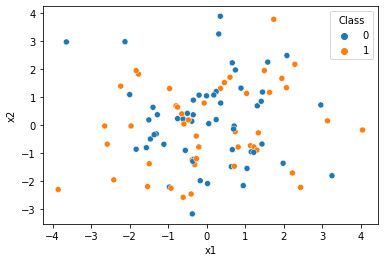

In [51]:
Xdat = pd.DataFrame({"x1": X[:,0],  "x2": X[:, 1], "Class": z, "individual": y})
sns.scatterplot(x="x1", y="x2", data=Xdat, hue="Class")

# Effect

In [52]:
X, y, z = gaussian_onesample(50, 2, 2, 2, effect_size=1)

w, b, ratio = statistic(X, y, z)
print("Within: {:3f}".format(w))
print("Between: {:3f}".format(b))
print("Ratio: {:3f}".format(ratio))

Within: 0.817510
Between: 0.872583
Ratio: 1.067368


<AxesSubplot:xlabel='x1', ylabel='x2'>

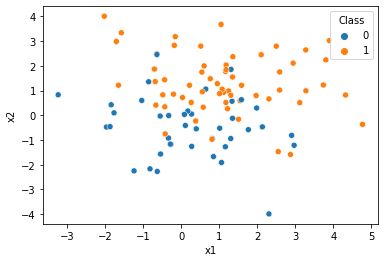

In [53]:
Xdat = pd.DataFrame({"x1": X[:,0],  "x2": X[:, 1], "Class": z, "individual": y})
sns.scatterplot(x="x1", y="x2", data=Xdat, hue="Class")

# Circle

In [55]:
X, y, z = ballcirc_onesample(50, 2, 2, 2)

w, b, ratio = statistic(X, y, z)
print("Within: {:3f}".format(w))
print("Between: {:3f}".format(b))
print("Ratio: {:3f}".format(ratio))

Within: 0.907614
Between: 0.963628
Ratio: 1.061716


<AxesSubplot:xlabel='x1', ylabel='x2'>

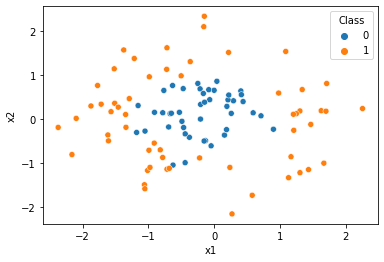

In [56]:
Xdat = pd.DataFrame({"x1": X[:,0],  "x2": X[:, 1], "Class": z, "individual": y})
sns.scatterplot(x="x1", y="x2", data=Xdat, hue="Class")

# Asymptotic Consistency of $w$ and $b$

In [ ]:
outer_reps = 200
ws = []
bs = []
Nsubs = []
for Nsub in np.floor(2**np.linspace(4, 8, num=10)):
    print(int(Nsub))
    for i in range(outer_reps):
        X, y, z = simulate_gaussian_eff(int(Nsub), 2, 2, 2)
        w, b, ratio = statistic(X, y, z)
        ws.append(w)
        bs.append(b)
        Nsubs.append(Nsub)

In [ ]:
data = pd.DataFrame({"Within": ws, "Between": bs, "Number": Nsubs})
data["B/W"] = data["Between"]/data["Within"]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=data, x="Number", y="Within", ax=axs[0], ci="sd")
sns.lineplot(data=data, x="Number", y="Between", ax=axs[1], ci="sd")
sns.lineplot(data=data, x="Number", y="B/W", ax=axs[2], ci="sd")
axs[0].set_ylabel("Within Subject Discr")
axs[1].set_ylabel("Between Subject Discr")
axs[2].set_ylabel("B/W Ratio")
axs[0].set_xlabel("N")
axs[1].set_xlabel("N")
axs[2].set_xlabel("N")

## One sample test

\begin{align*}
    H_0 : r = r_c\text{ against }H_A: r > r_c
\end{align*}
Where $r_c$ is the ratio $\frac{b_c}{w_c}$ if the class difference were $0$; that is, $\beta = 0_d$.

In [ ]:
ncores = 6
client = Client(threads_per_worker=1, n_workers=ncores)
client

In [ ]:
outer_reps = 100
pvalues = []
Nsubs = []
Nbreaks = 8
T = 3
ndim = 2
reps = 100

def run_exp_ost(row):
    if row[0] == "Gaussian":
        X, y, z = gaussian_onesample(int(row[1]), T, ndim, 2)
    if row[0] == "No Effect":
        X, y, z = noeff_onesample(int(row[1]), T, ndim, 2)
    if row[0] == "Circle/Disc":
        X, y, z = ballcirc_onesample(int(row[1]), T, ndim, 2)
    _, pvalue_cdiscr, _ = one_sample_test(X, y, z, reps=reps)
    pvalue_manova = one_sample_manova(X, y, z)
    _, pvalue_dcorr = one_sample_dcorr(X, z, reps=reps)
    return (row[0], row[1], row[2], pvalue_cdiscr, pvalue_manova, pvalue_dcorr)

exps = []
for exp_type in ["No Effect", "Gaussian", "Circle/Disc"]:
    for Nsub in np.floor(2**np.linspace(3, 8, num=Nbreaks)):
        for i in range(outer_reps):
            exps.append([exp_type, int(Nsub), i])

sim_exps = pd.DataFrame(exps, columns=["Simulation", "NSubs", "ID"])
print(sim_exps.head())
print(sim_exps.shape)

In [ ]:
sim_exps = ddf.from_pandas(sim_exps, npartitions=int(ncores*1.5))
sim_results = sim_exps.apply(lambda x: run_exp_ost(x), axis=1, result_type="expand",
                            meta={0: object, 1: int, 2: int, 3: float, 4: float, 5: float})
sim_results

In [ ]:
sim_results = sim_results.compute(scheduler="multiprocessing")
sim_results = sim_results.rename(columns={0: "Simulation", 1: "NSubs", 2: "index", 3: "pvalue_cdiscr",
                                          4: "pvalue_manova", 5: "pvalue_dcorr"})
sim_results.to_csv('./data/sims_onesample.csv')

In [ ]:
long_results = pd.wide_to_long(sim_results, stubnames="pvalue", i=["Simulation", "NSubs", "index"],
                               j="Statistic", sep="_", suffix='\\w+')

In [ ]:
alpha = .05
long_results["Outcome"] = long_results["pvalue"] < alpha
long_results_power = long_results.groupby(["Simulation", "NSubs", "Statistic"]).agg({"Outcome": np.mean})

In [ ]:
long_results_power